# 의사결정나무_실습

# Step0. 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import scale

import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split


# Step1. 데이터 구성하기

In [2]:
ds = pd.read_csv("통신고객이탈.csv", engine = 'python')
ds['CHURN'].replace(to_replace='Active', value = 0, inplace = True)
ds['CHURN'].replace(to_replace='Churned', value = 1, inplace = True)
ds.drop('CUSTOMER_ID', axis = 1, inplace = True)
ds.head()

,CHURN,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,0,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,0,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,0,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,0,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,0,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [3]:
ds.isnull().sum(axis = 0)

CHURN                 0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

## 더미변수 생성

In [4]:
ds_dummy = pd.get_dummies(ds)
ds_dummy.head()

,CHURN,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,...,HANDSET_S80,HANDSET_SOP10,HANDSET_SOP20,HANDSET_WC95,USAGE_BAND_High,USAGE_BAND_Low,USAGE_BAND_Med,USAGE_BAND_MedHigh,USAGE_BAND_MedLow,USAGE_BAND_None
0,0,31,33.33,6,218,379.8,9,21.6,366,632.4,...,0,0,0,0,0,0,1,0,0,0
1,0,27,30.87,10,373,656.4,11,28.0,411,810.4,...,0,0,0,0,0,0,1,0,0,0
2,0,27,49.40,11,260,582.0,0,0.0,265,614.1,...,0,0,0,0,0,0,1,0,0,0
3,0,61,48.60,1,294,661.8,14,101.5,326,844.0,...,0,0,0,0,0,0,1,0,0,0
4,0,52,56.03,0,221,555.6,7,25.0,274,673.0,...,0,0,0,0,0,0,1,0,0,0


## 데이터 분할 ( numpy의 random함수 이용)

In [5]:
np.random.seed(seed = 1234)
msk = np.random.rand(ds_dummy.shape[0]) < 0.7
ds_train = ds_dummy[msk]
ds_test = ds_dummy[~msk]

ds_train_y = ds_train['CHURN']
ds_train_x = ds_train.drop('CHURN', axis=1, inplace = False)
ds_test_y = ds_test['CHURN']
ds_test_x = ds_test.drop('CHURN', axis = 1, inplace = False)

print("train data X size : {}".format(ds_train_x.shape))
print("train data Y size : {}".format(ds_train_y.shape))
print("test data X size : {}".format(ds_test_x.shape))
print("test data Y size : {}".format(ds_test_y.shape))

train data X size : (635, 33)
train data Y size : (635,)
test data X size : (295, 33)
test data Y size : (295,)


## 데이터 분할(sklearn의 train_test_split 이용)

In [6]:
ds_y = ds_dummy['CHURN']
ds_x = ds_dummy.drop('CHURN', axis = 1, inplace = False)
ds_train_x2, ds_test_x2, ds_train_y2, ds_test_y2 = train_test_split(ds_x, ds_y, test_size = 0.30, random_state = 1234)

print("train data X size : {}".format(ds_train_x2.shape))
print("train data Y size : {}".format(ds_train_y2.shape))
print("test data X size : {}".format(ds_test_x2.shape))
print("test data y size : {}".format(ds_test_y2.shape))

train data X size : (651, 33)
train data Y size : (651,)
test data X size : (279, 33)
test data y size : (279,)


# Step2. 의사결정나무 모델 생성

In [7]:
tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(ds_train_x2, ds_train_y2)
print("Accuracy on training set : {:.3f}".format(tree_uncustomized.score(ds_train_x2, ds_train_y2)))
print("Accuracy on test set : {:.3f}".format(tree_uncustomized.score(ds_test_x2, ds_test_y2)))

Accuracy on training set : 1.000
Accuracy on test set : 0.853


## 의사결정나무 모델 parameter조정

In [8]:
train_accuracy = []
test_accuracy = []
para_criterion = ['gini', 'entropy']
for criterion in para_criterion:
    tree1 = DecisionTreeClassifier(criterion=criterion, random_state=1234)
    tree1.fit(ds_train_x, ds_train_y)
    train_accuracy.append(tree1.score(ds_train_x, ds_train_y))
    test_accuracy.append(tree1.score(ds_test_x, ds_test_y))
    
ds_accuracy1 = pd.DataFrame()
ds_accuracy1['Criterion'] = para_criterion
ds_accuracy1['TrainAccuracy'] = train_accuracy
ds_accuracy1['TestAccuracy'] = test_accuracy
ds_accuracy1.round(3)

,Criterion,TrainAccuracy,TestAccuracy
0,gini,1.0,0.851
1,entropy,1.0,0.831


In [9]:
train_accuracy = []; test_accuracy = []
para_criterion = []; para_max_depth = []
n_iter_depth = 10
list_criterion = ['gini','entropy']
for criterion in list_criterion:
    for depth in range(1, n_iter_depth + 1):
        tree2 = DecisionTreeClassifier(criterion=criterion, max_depth=depth, random_state=1234)
        tree2.fit(ds_train_x, ds_train_y)
        
        train_accuracy.append(tree2.score(ds_train_x, ds_train_y))
        test_accuracy.append(tree2.score(ds_test_x, ds_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(depth)

In [10]:
ds_accuracy2 = pd.DataFrame()
ds_accuracy2['Criterion'] = para_criterion
ds_accuracy2['Depth']= para_max_depth
ds_accuracy2['TrainAccuracy'] = train_accuracy
ds_accuracy2['TestAccuracy'] = test_accuracy
ds_accuracy2.round(3)

,Criterion,Depth,TrainAccuracy,TestAccuracy
0,gini,1,0.843,0.851
1,gini,2,0.871,0.878
2,gini,3,0.896,0.892
3,gini,4,0.907,0.834
4,gini,5,0.928,0.881
5,gini,6,0.935,0.871
6,gini,7,0.951,0.864
7,gini,8,0.956,0.864
8,gini,9,0.978,0.864
9,gini,10,0.992,0.851


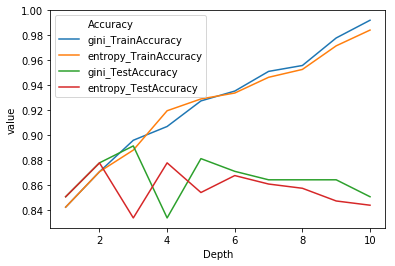

In [11]:
ds_accuracy2_melt = pd.melt(ds_accuracy2, id_vars=['Criterion', 'Depth'])
ds_accuracy2_melt['Accuracy'] = ds_accuracy2_melt['Criterion'] + "_" + ds_accuracy2_melt['variable']
sns.lineplot(x='Depth', y = 'value', hue='Accuracy', data=ds_accuracy2_melt)

## criterion = gini, depth = 3일때 test 정확도가 가장 높았다.

In [12]:
train_accuracy = []; test_accuracy = []
para_criterion = []; para_max_depth = []; para_min_leaf_size = []
max_depth = 10
list_min_leaf_size = [i*10 for i in range(1, 6)]
for criterion in list_criterion:
    for leafsize in list_min_leaf_size:
        tree3 = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=leafsize, random_state=1234)
        tree3.fit(ds_train_x, ds_train_y)
        train_accuracy.append(tree3.score(ds_train_x, ds_train_y))
        test_accuracy.append(tree3.score(ds_test_x, ds_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(max_depth)
        para_min_leaf_size.append(leafsize)

In [13]:
ds_accuracy3= pd.DataFrame()
ds_accuracy3['Criterion'] = para_criterion
ds_accuracy3['Depth'] = para_max_depth
ds_accuracy3['MinLeafSize'] = para_min_leaf_size
ds_accuracy3['TrainAccuracy'] = train_accuracy
ds_accuracy3['TestAccuracy'] = test_accuracy
ds_accuracy3.round(3)

,Criterion,Depth,MinLeafSize,TrainAccuracy,TestAccuracy
0,gini,10,10,0.920,0.892
1,gini,10,20,0.896,0.864
2,gini,10,30,0.868,0.817
3,gini,10,40,0.817,0.773
4,gini,10,50,0.808,0.803
5,entropy,10,10,0.920,0.902
6,entropy,10,20,0.885,0.824
7,entropy,10,30,0.868,0.817
8,entropy,10,40,0.828,0.783
9,entropy,10,50,0.820,0.780


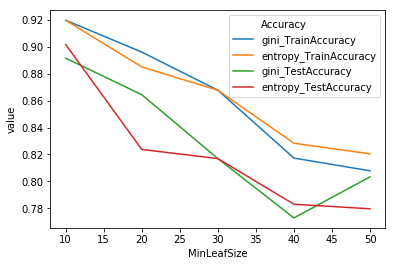

In [14]:
ds_accuracy3_melt = pd.melt(ds_accuracy3, id_vars=['Criterion', 'Depth', 'MinLeafSize'])
ds_accuracy3_melt['Accuracy'] = ds_accuracy3_melt['Criterion'] + "_" + ds_accuracy3_melt['variable']
sns.lineplot(x = 'MinLeafSize', y = 'value', hue = 'Accuracy', data = ds_accuracy3_melt)

# Step3. 의사결정나무 모델 시각화

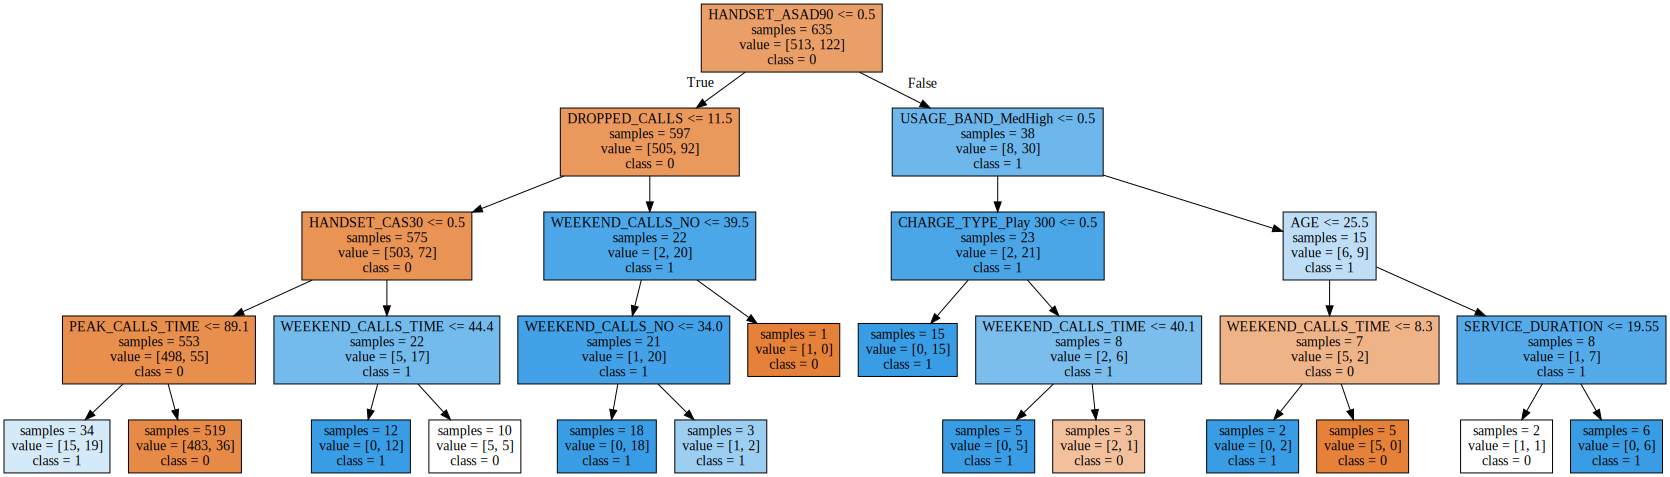

In [15]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1234)
tree.fit(ds_train_x, ds_train_y)
export_graphviz(tree, out_file='tree.dot', class_names=['0','1'],
               feature_names=ds_train_x.columns, impurity=False, filled = True)
with open("tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

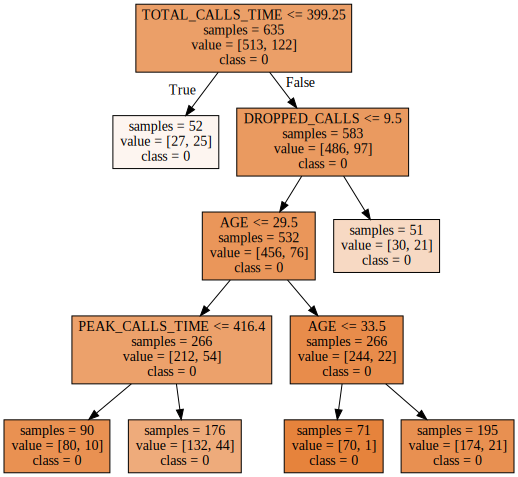

In [16]:
tree4 = DecisionTreeClassifier(criterion ='gini', max_depth=4, min_samples_leaf=50, random_state=1234)
tree5 = tree4.fit(ds_train_x, ds_train_y)
export_graphviz(tree5, out_file="tree2.dot", class_names=['0','1'],
               feature_names=ds_train_x.columns, impurity=False, filled=True)
with open("tree2.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# Step4. 결론 도출

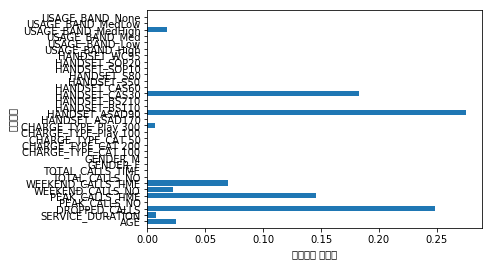

In [17]:
ds_feature_importance = pd.DataFrame()
ds_feature_importance['Feature'] = ds_train_x.columns
ds_feature_importance['Importance'] = tree.feature_importances_

ds_feature_importance.sort_values("Importance", ascending = False, inplace = True)
ds_feature_importance.round(3)
def plot_feature_importances(model):
    n_features = ds_train_x.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align = 'center')
    plt.yticks(np.arange(n_features), ds_train_x.columns)
    plt.xlabel("설명변수 중요도")
    plt.ylabel("설명변수")
    plt.ylim(-1, n_features)
plot_feature_importances(tree)

## HANDSET이 ASAD90인 경우 중요도가 가장 크다.